In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import h5py
import numpy as np
import scipy.optimize
import jax.numpy as jnp

import proplot as pplt

In [2]:
d = h5py.File("/Users/beckermr/Desktop/sompz_y6_imsim_400Tile.hdf5")

In [3]:
nzs = {}
for _bin in range(4):
    nzs[_bin] = d[f"catalog/sompz/pzdata/bin{_bin}"][:]
zlow = d["catalog/sompz/pzdata/zlow"][:]
zhigh = d["catalog/sompz/pzdata/zhigh"][:]

In [4]:
z = (zlow + zhigh)/2
dz = z[1] - z[0]

## Smail

[1.14648218 0.34029106 2.04289702]
[2.21775509 0.6243003  4.70982814]
[24.76555919  0.04937127  1.11203904]
[13.6154501   0.07869246  0.99273217]


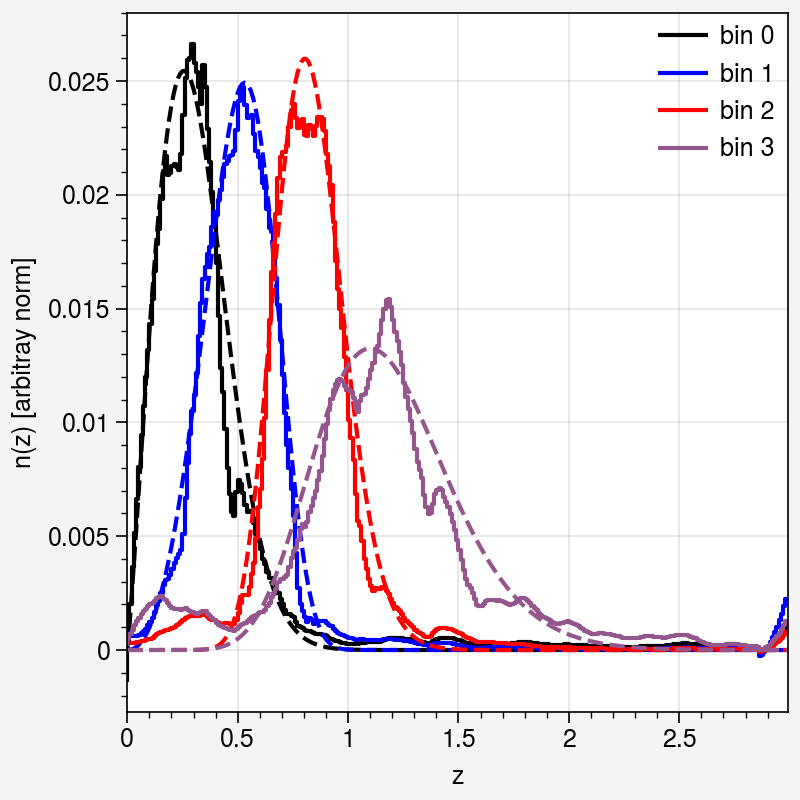

In [82]:
@jax.jit
def smail_nrm(z, a, b, c):
    vals = jnp.power(z, a) * jnp.exp(-jnp.power(z/b, c))
    return vals / jnp.sum(vals)


fig, axs = pplt.subplots(figsize=(4, 4))

popt = None
for i, col in enumerate(["black", "blue", "red", "purple"]):
    popt, pcov = scipy.optimize.curve_fit(
        smail_nrm,
        z,
        nzs[i] / np.sum(nzs[i]),
        p0=(1, 1, 1) if popt is None else popt,
        ftol=1e-3,
        gtol=1e-3,
    )
    print(popt)

    axs.plot(z, nzs[i] / np.sum(nzs[i]), drawstyle="steps", color=col, label=f"bin {i}")
    axs.plot(z, smail_nrm(z, *popt), linestyle="dashed", color=col)

axs.format(xlabel="z", ylabel="n(z) [arbitray norm]")
axs.legend(loc="ur", frameon=False, ncols=1)

In [77]:
def smail(z, a, b, c):
    z = jnp.where(z > 0.0, z, 1e-300)
    return jnp.where(
        z > 0.0,
        jnp.power(z, a) * jnp.exp(-jnp.power(z/b, c)),
        0.0,
    )


def _safe_div(numer, denom):
    denom = jnp.where(
        (numer == 0) & (denom == 0),
        1.0,
        denom,
    )
    return jnp.where(
        (numer == 0) & (denom == 0),
        0.0,
        numer / denom,
    )


smail_d1 = jax.grad(smail)
smail_d2 = jax.grad(smail_d1)


def _fmodel_smail2(z, a0, a1, a2, smail_params):
    val = smail(z, *smail_params)
    val_d1 = smail_d1(z, *smail_params)
    val_d2 = smail_d2(z, *smail_params)
    return a0 + a1 * _safe_div(val_d1, val) + a2 * _safe_div(val_d2, val) / 2.0


fmodel_smail2 = jax.jit(
    jax.vmap(_fmodel_smail2, in_axes=[0, None, None, None, (None, None, None)]),
    static_argnames=["smail_params"],
)

<a list of 1 Line2D objects>

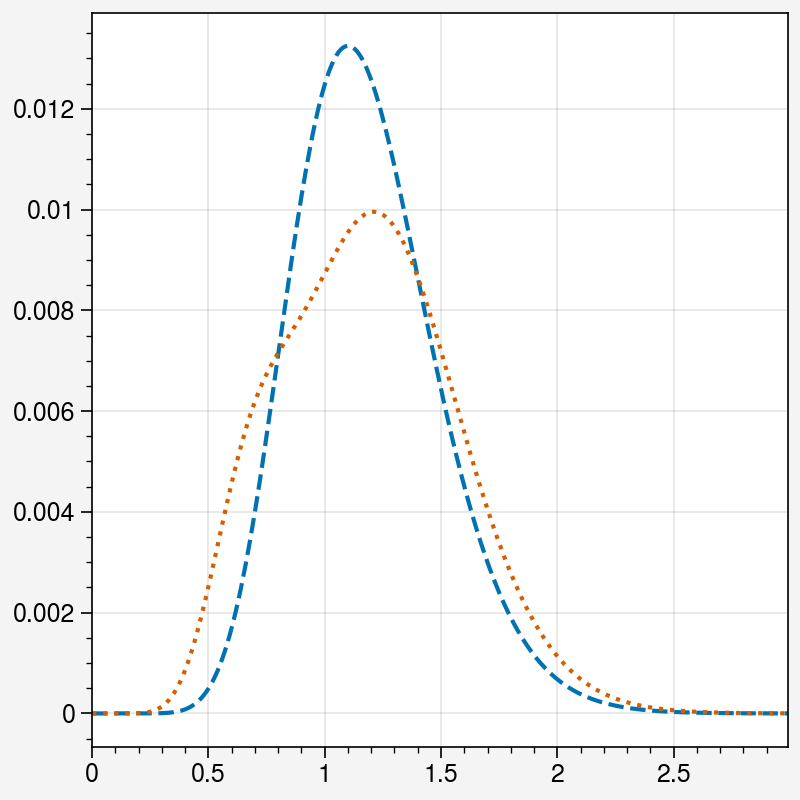

In [103]:
fig, axs = pplt.subplots(figsize=(4, 4))

i = 3
fac = 1.0 + fmodel_smail2(z, 0.0, 0, 5e-2, tuple(popt.tolist()))

# axs.plot(z, nzs[i] / np.sum(nzs[i]), drawstyle="steps", label=f"bin {i}")
axs.plot(z, smail_nrm(z, *popt), linestyle="dashed")

# axs.plot(z, nzs[i] / np.sum(nzs[i]) * fac, drawstyle="steps", linestyle="dotted", label=f"bin {i}")
axs.plot(z, smail_nrm(z, *popt) * fac, linestyle="dotted")

## Akima

In [250]:
import functools

import jax
import jax.numpy as jnp
import numpy as np


def akima_interp_coeffs(x, y, use_jax=True):
    """Compute the interpolation coefficients for an Akima cubic spline.

    An Akima cubic spline is a piecewise C(1) cubic polynomial that interpolates a set of
    points (x, y). Unlike a more traditional cubic spline, the Akima spline can be computed
    without solving a linear system of equations. However, the Akima spline does not have
    continuous second derivatives at the interpolation points.

    See https://en.wikipedia.org/wiki/Akima_spline and
    Akima (1970), "A new method of interpolation and smooth curve fitting based on local procedures",
    Journal of the ACM. 17: 589-602 for a description of the technique.

    Parameters
    ----------
    x : array-like
        The x-coordinates of the data points. These must be sorted into increasing order
        and cannot contain any duplicates.
    y : array-like
        The y-coordinates of the data points.
    use_jax : bool, optional
        Whether to use JAX for computation. Default is True. If False, the
        coefficients are computed using NumPy on the host device. This can be
        useful when embded inside JAX code w/ JIT applied to pre-compute the
        coefficients.

    Returns
    -------
    tuple
        A tuple of arrays (a, b, c, d) where each array has shape (N-1,) and
        contains the coefficients for the cubic polynomial that interpolates
        the data points between x[i] and x[i+1].
    """
    if use_jax:
        return _akima_interp_coeffs_jax(x, y)
    else:
        return _akima_interp_coeffs_nojax(x, y)


def _akima_interp_coeffs_nojax(x, y):
    dx = x[1:] - x[:-1]
    mi = (y[1:] - y[:-1]) / dx

    # these values are imposed for points
    # at the ends
    s0 = mi[0:1]
    s1 = (mi[0:1] + mi[1:2]) / 2.0
    snm2 = (mi[-3:-2] + mi[-2:-1]) / 2.0
    snm1 = mi[-2:-1]

    wim1 = np.abs(mi[3:] - mi[2:-1])
    wi = np.abs(mi[1:-2] - mi[0:-3])
    denom = wim1 + wi
    numer = wim1 * mi[1:-2] + wi * mi[2:-1]

    msk_denom = np.abs(denom) >= 1e-12
    smid = np.zeros_like(denom)
    smid[msk_denom] = numer[msk_denom] / denom[msk_denom]
    smid[~msk_denom] = (mi[1:-2][~msk_denom] + mi[2:-1][~msk_denom]) / 2.0
    s = np.concatenate([s0, s1, smid, snm2, snm1])

    # these coeffs are for
    # P(x) = a + b * (x-xi) + c * (x-xi)**2 + d * (x-xi)**3
    # for a point x that falls in [xi, xip1]
    a = y[:-1]
    b = s[:-1]
    c = (3 * mi - 2 * s[:-1] - s[1:]) / dx
    d = (s[:-1] + s[1:] - 2 * mi) / dx / dx

    return (a, b, c, d)


@jax.jit
def _akima_interp_coeffs_jax(x, y):
    dx = x[1:] - x[:-1]
    mi = (y[1:] - y[:-1]) / dx

    # these values are imposed for points
    # at the ends
    s0 = mi[0:1]
    s1 = (mi[0:1] + mi[1:2]) / 2.0
    snm2 = (mi[-3:-2] + mi[-2:-1]) / 2.0
    snm1 = mi[-2:-1]

    wim1 = jnp.abs(mi[3:] - mi[2:-1])
    wi = jnp.abs(mi[1:-2] - mi[0:-3])
    denom = wim1 + wi
    numer = wim1 * mi[1:-2] + wi * mi[2:-1]

    smid = jnp.where(
        jnp.abs(denom) >= 1e-12,
        numer / denom,
        (mi[1:-2] + mi[2:-1]) / 2.0,
    )
    s = jnp.concatenate([s0, s1, smid, snm2, snm1])

    # these coeffs are for
    # P(x) = a + b * (x-xi) + c * (x-xi)**2 + d * (x-xi)**3
    # for a point x that falls in [xi, xip1]
    a = y[:-1]
    b = s[:-1]
    c = (3 * mi - 2 * s[:-1] - s[1:]) / dx
    d = (s[:-1] + s[1:] - 2 * mi) / dx / dx

    return (a, b, c, d)


def akima_interp(x, xp, yp, coeffs):
    """Conmpute the values of an Akima cubic spline at a set of points given the
    interpolation coefficients.

    Parameters
    ----------
    x : array-like
        The x-coordinates of the points where the interpolation is computed.
    xp : array-like
        The x-coordinates of the data points. These must be sorted into increasing order
        and cannot contain any duplicates.
    yp : array-like
        The y-coordinates of the data points. Not used currently.
    coeffs : tuple
        The interpolation coefficients returned by `akima_interp_coeffs`.

    Returns
    -------
    array-like
        The values of the Akima cubic spline at the points x.
    """
    xp = jnp.asarray(xp)
    # yp = jnp.array(yp)  # unused
    if True:
        dxp = xp[1] - xp[0]
        i = jnp.floor((x - xp[0]) / dxp).astype(jnp.int32)
        i = jnp.clip(i, 0, len(xp) - 2)
    else:
        i = jnp.clip(jnp.searchsorted(xp, x, side="right"), 1, len(xp) - 1) - 1

    # these coeffs are for
    # P(x) = a + b * (x-xi) + c * (x-xi)**2 + d * (x-xi)**3
    # for a point x that falls in [xi, xip1]
    a, b, c, d = coeffs
    a = jnp.asarray(a)
    b = jnp.asarray(b)
    c = jnp.asarray(c)
    d = jnp.asarray(d)

    dx = x - xp[i]
    dx2 = dx * dx
    dx3 = dx2 * dx
    xval = a[i] + b[i] * dx + c[i] * dx2 + d[i] * dx3

    xval = jnp.where(x < xp[0], 0, xval)
    xval = jnp.where(x > xp[-1], 0, xval)
    return xval


akima_interp_d1 = jax.grad(akima_interp)
akima_interp_d2 = jax.grad(akima_interp_d1)
akima_interp_d3 = jax.grad(akima_interp_d2)
akima_interp_d4 = jax.grad(akima_interp_d3)

def _fmodel_akima2(z, a0, a1, a2, xp, yp, coeffs):
    val = akima_interp(z, xp, yp, coeffs)
    val_d1 = akima_interp_d1(z, xp, yp, coeffs)
    val_d2 = akima_interp_d2(z, xp, yp, coeffs)
    return a0 + a1 * _safe_div(val_d1, val) + a2 * _safe_div(val_d2, val) / 2.0


fmodel_akima2 = jax.jit(
    jax.vmap(_fmodel_akima2, in_axes=[0, None, None, None, None, None, None]),
)


def _fmodel_akima4(z, a0, a1, a2, a3, a4, xp, yp, coeffs):
    val = akima_interp(z, xp, yp, coeffs)
    val_d1 = akima_interp_d1(z, xp, yp, coeffs)
    val_d2 = akima_interp_d2(z, xp, yp, coeffs)
    val_d3 = akima_interp_d3(z, xp, yp, coeffs)
    val_d4 = akima_interp_d4(z, xp, yp, coeffs)
    return (
        a0
        - a1 * _safe_div(val_d1, val)
        + a2 * _safe_div(val_d2, val) / 2.0
        - a3 * _safe_div(val_d3, val) / 6.0
        + a4 * _safe_div(val_d4, val) / 24.0
    )


fmodel_akima4 = jax.jit(
    jax.vmap(_fmodel_akima4, in_axes=[0, None, None, None, None, None, None, None, None]),
)

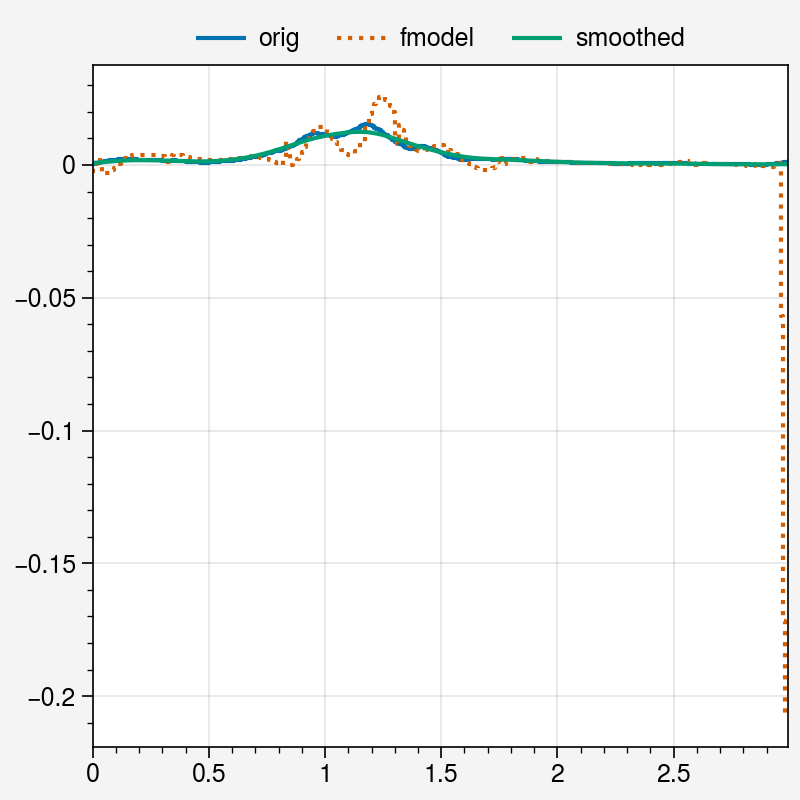

In [257]:
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

i = 3
nzi = nzs[i].astype(np.float64)

nzi_smooth = savgol_filter(nzi, 20, 1, mode='constant', cval=0.0)
nzi_smooth = gaussian_filter1d(nzi, 10, mode='constant', cval=0.0)
nzi_smooth /= np.sum(nzi_smooth)

coeffs = akima_interp_coeffs(z, nzi_smooth, use_jax=False)
fac = 1.0 + fmodel_akima4(z, 0.0, 0e-2, 0e-2, 1e-2, 0, z, nzi_smooth, coeffs)
nzi_fmodel = nzs[i] / np.sum(nzs[i]) * fac
nzi_fmodel /= np.sum(nzi_fmodel)

fig, axs = pplt.subplots(figsize=(4, 4))


axs.plot(z, nzs[i] / np.sum(nzs[i]), drawstyle="steps", label="orig")

axs.plot(z, nzs[i] / np.sum(nzs[i]) * fac, drawstyle="steps", linestyle="dotted", label=f"fmodel")
axs.plot(z, nzi_smooth / np.sum(nzi_smooth), label="smoothed")
# axs.plot(z, fac, linestyle="dotted")

axs.legend(loc="t", frameon=False, ncols=3)

In [166]:
z[::nmod]

array([0., 1., 2.])

## Modified Student's t

[0.27948404 0.15157989]
1.1221183489706316e-24
[0.51605336 0.14934015]
1.9551595694103558e-25
[0.81613285 0.14245711]
3.510315639549662e-26
[1.12875427 0.27467092]
5.971151126099324e-26


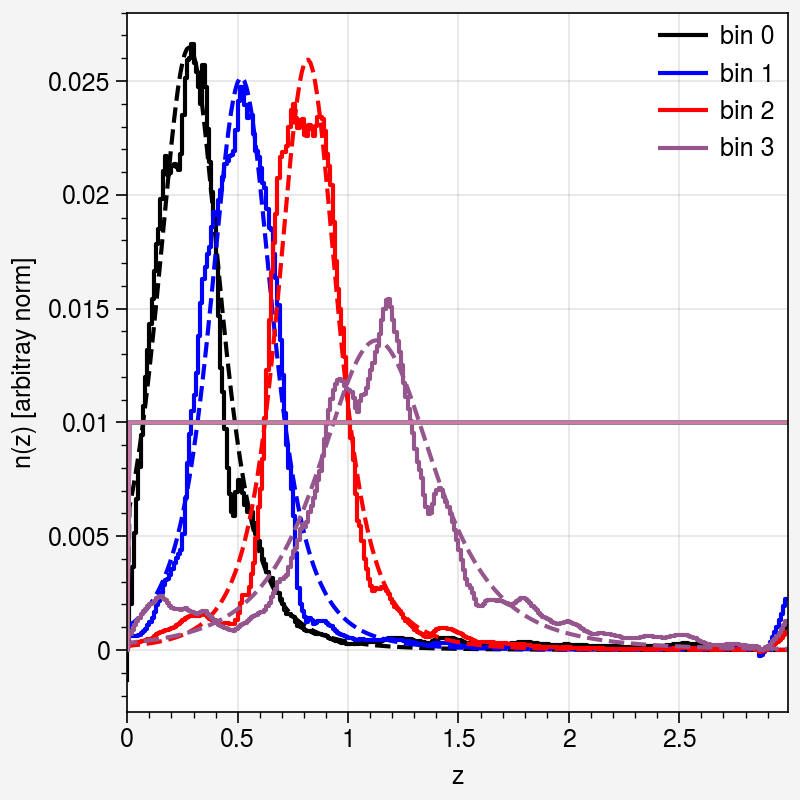

In [25]:
def stud_trunc(z):
    # return jnp.ones_like(z)
    return jax.nn.sigmoid((z - dz/2) / (dz / 100))

@jax.jit
def stud(z, mu, sigma):
    nu = 3
    znrm = (z - mu) / sigma
    vals = jnp.power(1 + znrm * znrm / nu, -(nu + 1)/2)
    vals = vals * stud_trunc(z)
    return vals


@jax.jit
def stud_nrm(z, mu, sigma):
    vals = stud(z, mu, sigma)
    return vals / jnp.sum(vals)


fig, axs = pplt.subplots(figsize=(4, 4))

params = {}
popt = None
for i, col in enumerate(["black", "blue", "red", "purple"]):
    popt, pcov = scipy.optimize.curve_fit(
        stud_nrm,
        z,
        nzs[i] / np.sum(nzs[i]),
        p0=(1, 0.1) if popt is None else popt,
    )
    print(popt)
    params[i] = popt

    axs.plot(z, nzs[i] / np.sum(nzs[i]), drawstyle="steps", color=col, label=f"bin {i}")
    axs.plot(z, stud_nrm(z, *popt), linestyle="dashed", color=col)
    axs.plot(z, stud_trunc(z) * 0.01)
    print(stud(0.0, *popt) / jnp.sum(stud(z, *popt)))

axs.format(xlabel="z", ylabel="n(z) [arbitray norm]")
axs.legend(loc="ur", frameon=False, ncols=1)

In [26]:


def _safe_div(numer, denom):
    denom = jnp.where(
        (denom == 0),
        1.0,
        denom,
    )
    return jnp.where(
        (numer == 0) & (denom == 0),
        0.0,
        numer / denom,
    )


stud_d1 = jax.grad(stud)
stud_d2 = jax.grad(stud_d1)
stud_d3 = jax.grad(stud_d2)
stud_d4 = jax.grad(stud_d3)


def _fmodel_stud4(z, a0, a1, a2, a3, a4, mu, sigma):
    val = stud(z, mu, sigma)
    val_d1 = stud_d1(z, mu, sigma)
    val_d2 = stud_d2(z, mu, sigma)
    val_d3 = stud_d3(z, mu, sigma)
    val_d4 = stud_d4(z, mu, sigma)

    return (
        a0
        - a1 * _safe_div(val_d1, val)
        + a2 * _safe_div(val_d2, val) / 2.0
        - a3 * _safe_div(val_d3, val) / 6.0
        + a4 * _safe_div(val_d4, val) / 24.0
    )


fmodel_stud4 = jax.jit(
    jax.vmap(_fmodel_stud4, in_axes=[0, None, None, None, None, None, None, None]),
)

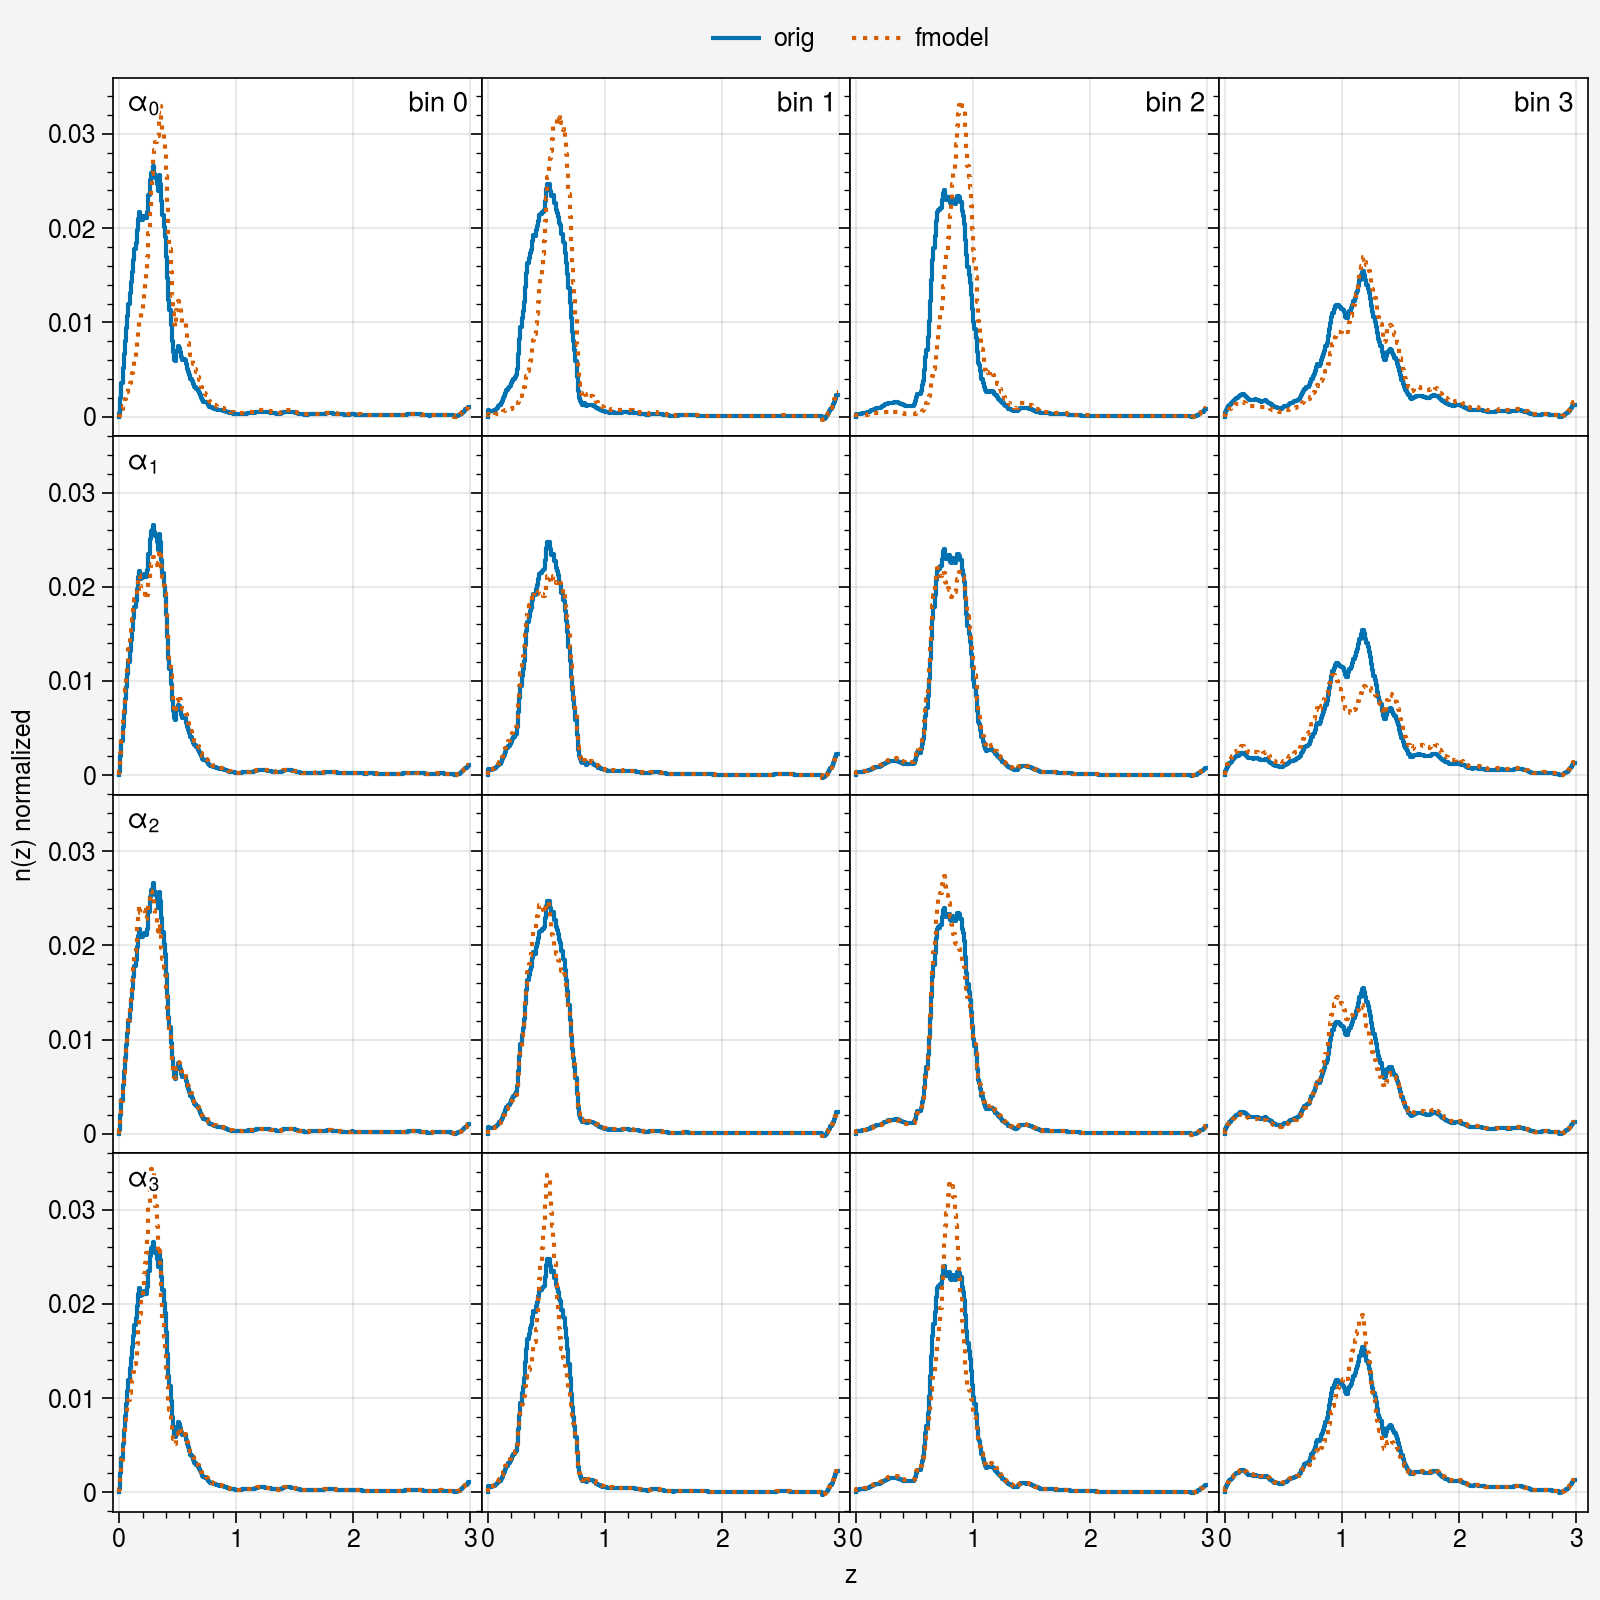

In [27]:

scales = np.array([1e-1, 5e-3, 1e-3, 5e-4])

fig, axs = pplt.subplots(ncols=4, nrows=4, figsize=(8, 8), share=4, wspace=0, hspace=0)

for i in range(4):
    for row in range(4):
        ax = axs[row, i]
        avec = np.zeros(4)
        avec[row] = scales[row]
        if i == 3 and row > 0:
            avec *= 10

        nzi = nzs[i].astype(np.float64).copy()
        nzi[0] = 0.0
        nzi = nzi / np.sum(nzi)
        stud_params = tuple(params[i].tolist())

        morig = ax.plot(z, nzi, drawstyle="steps", label="orig")

        fac = 1.0 + fmodel_stud4(z, 0.0, avec[0], avec[1], avec[2], avec[3], stud_params[0], stud_params[1])
        nzi_fmodel = nzi * fac
        nzi_fmodel /= np.sum(nzi_fmodel)
        mmod = ax.plot(z, nzi_fmodel, drawstyle="steps", linestyle="dotted", label="fmodel")

        # fac = 1.0 + fmodel_stud4(z, 0.0, 0e-1, 0e-3, 0e-3, 0e-4, stud_params[0], stud_params[1])
        # nzi_fmodel = nzi * fac
        # nzi_fmodel /= np.sum(nzi_fmodel)
        # mmod = ax.plot(z, nzi_fmodel, drawstyle="steps", linestyle="dotted", label="fmodel")

        # axs.plot(z, fac, linestyle="dotted")
        ax.format(xlim=(-0.05, 3.1))
        if row == 0:
            ax.format(urtitle=f"bin {i}")
        if i == 0:
            ax.format(ultitle=f"$\\alpha_{row}$", ylabel="n(z) normalized")
        if row == 3:
            ax.format(xlabel="z")

fig.legend([morig, mmod], loc="t", frameon=False, ncols=3)

## Log-Normal

[-1.16081426  0.83199015]
[-0.63882195  0.45115716]
[-0.19120157  0.2675685 ]
[0.15403096 0.37867465]


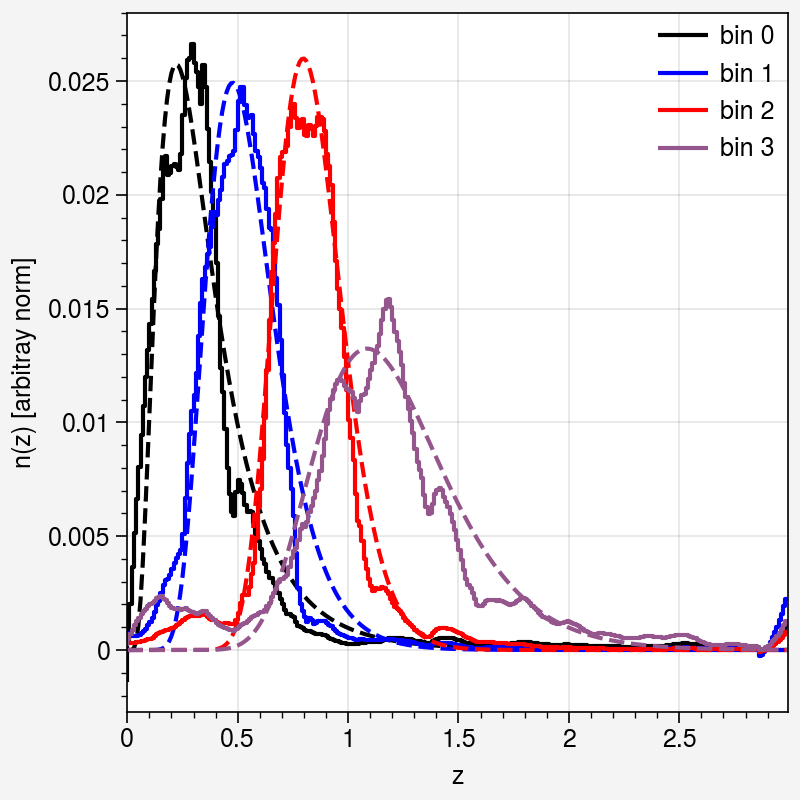

In [396]:

@jax.jit
def lognorm(z, mu, sigma):
    z = jnp.where(z <= 0, 1e-16, z)
    arg = (jnp.log(z) - mu) / sigma
    vals = jnp.exp(-arg * arg) / z / sigma / jnp.sqrt(2.0 * jnp.pi)
    return jnp.where(z <= 0, 0.0, vals)

@jax.jit
def lognorm_nrm(z, mu, sigma):
    vals = lognorm(z, mu, sigma)
    return vals / jnp.sum(vals)


fig, axs = pplt.subplots(figsize=(4, 4))

params = {}
popt = None
for i, col in enumerate(["black", "blue", "red", "purple"]):
    popt, pcov = scipy.optimize.curve_fit(
        lognorm_nrm,
        z,
        nzs[i] / np.sum(nzs[i]),
        p0=(1, 1) if popt is None else popt,
    )
    print(popt)
    params[i] = popt

    axs.plot(z, nzs[i] / np.sum(nzs[i]), drawstyle="steps", color=col, label=f"bin {i}")
    axs.plot(z, lognorm_nrm(z, *popt), linestyle="dashed", color=col)

axs.format(xlabel="z", ylabel="n(z) [arbitray norm]")
axs.legend(loc="ur", frameon=False, ncols=1)

In [400]:
def _safe_div(numer, denom):
    denom = jnp.where(
        (denom == 0),
        1.0,
        denom,
    )
    return jnp.where(
        (numer == 0) & (denom == 0),
        0.0,
        numer / denom,
    )


lognorm_d1 = jax.grad(lognorm)
lognorm_d2 = jax.grad(lognorm_d1)
lognorm_d3 = jax.grad(lognorm_d2)
lognorm_d4 = jax.grad(lognorm_d3)


def _fmodel_lognorm4(z, a0, a1, a2, a3, a4, mu, sigma):
    val = lognorm(z, mu, sigma)
    val_d1 = lognorm_d1(z, mu, sigma)
    val_d2 = lognorm_d2(z, mu, sigma)
    val_d3 = lognorm_d3(z, mu, sigma)
    val_d4 = lognorm_d4(z, mu, sigma)

    return (
        a0
        - a1 * _safe_div(val_d1, val)
        + a2 * _safe_div(val_d2, val) / 2.0
        - a3 * _safe_div(val_d3, val) / 6.0
        + a4 * _safe_div(val_d4, val) / 24.0
    )


fmodel_lognorm4 = jax.jit(
    jax.vmap(_fmodel_lognorm4, in_axes=[0, None, None, None, None, None, None, None]),
)

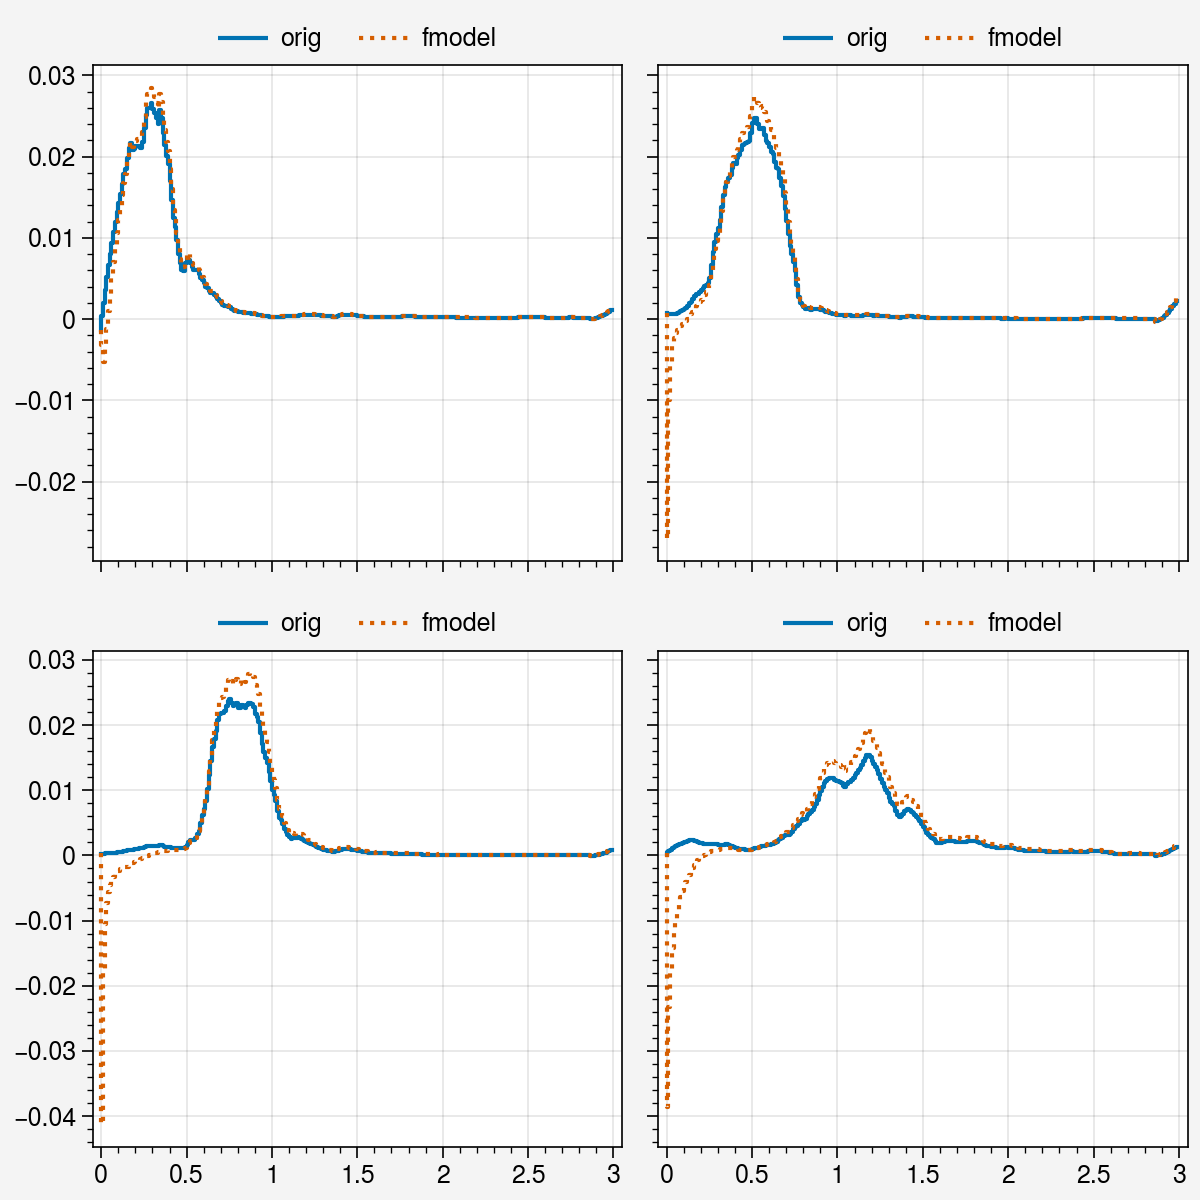

In [405]:

fig, axs = pplt.subplots(ncols=2, nrows=2, figsize=(6, 6))

for i, ax in enumerate(axs):

    nzi = nzs[i].astype(np.float64)
    nzi = nzi / np.sum(nzi)
    lognorm_params = tuple(params[i].tolist())

    fac = 1.0 + fmodel_lognorm4(z, 0.0, 1e-2, 0e-2, 0e-3, 0e-4, lognorm_params[0], lognorm_params[1])
    nzi_fmodel = nzi * fac
    nzi_fmodel /= np.sum(nzi_fmodel)

    ax.plot(z, nzi, drawstyle="steps", label="orig")

    ax.plot(z, nzi_fmodel, drawstyle="steps", linestyle="dotted", label="fmodel")
    # axs.plot(z, fac, linestyle="dotted")
    ax.format(xlim=(-0.05, 3.05))

    ax.legend(loc="t", frameon=False, ncols=3)